# Retrieval and preparation of the iris dataset

This code downloads the iris dataset provided by the scikit-learn library.

In [118]:
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()

Splitting the dataset with a standard 80-20 split where 80% is used for training and the remaining 20% to evaluate a models generalization capabilities.

In [119]:
from sklearn.model_selection import train_test_split
X_train, _, y_train, _ = train_test_split(iris.data, iris.target, train_size=0.8, random_state=0, stratify=iris.target)

Preparing the data as a pandas data frame.

In [120]:
features_df = pd.DataFrame(X_train, columns=iris.feature_names)
target_df = pd.DataFrame(y_train, columns=['species.code'])


Adding a species column that includes the specific species label instead of just a numeric code.

In [121]:
target_df['species'] = target_df['species.code'].map(lambda x: iris.target_names[x])
target_df.head()

,species.code,species
0,0,setosa
1,0,setosa
2,0,setosa
3,0,setosa
4,1,versicolor


Concatenating the features and target into one data frame.

In [122]:
iris_df = pd.concat([features_df, target_df], axis=1)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species.code,species
0,4.8,3.0,1.4,0.3,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.4,3.0,1.3,0.2,0,setosa
3,5.0,3.4,1.5,0.2,0,setosa
4,5.8,2.7,3.9,1.2,1,versicolor


# EDA

Starting visualization with a simple scatter plot. To reduce the number of features to produce a simple 2D scatter plot PCA has been used to reduce the dimensionality of the feature space. As can be seen below the resulting features explain roughly 97.8% of the variance of the dataset. So despite halving the dimensionality of the feature space, most of its variability is preserved.

In [123]:
from sklearn.decomposition import PCA

columns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

pca = PCA(n_components=2)
pca.fit(iris_df[columns])
iris_pca_features_df = pd.DataFrame(pca.transform(iris_df[columns]), columns=['x', 'y'])
iris_pca_df = pd.concat([iris_pca_features_df, target_df], axis=1)
pca.explained_variance_ratio_.sum()

0.9794004921552476

The plot shows that flowers of the species 'Setosa' are more strongly separated from the other species. Flowers of the species 'Versicolor' and 'Virginica' on the other hand, exhibit a certain amount of overlap.

[Text(0.5, 1.0, 'Scatter plot of the iris dataset with the feature space reduced to a dimensionality of two.')]

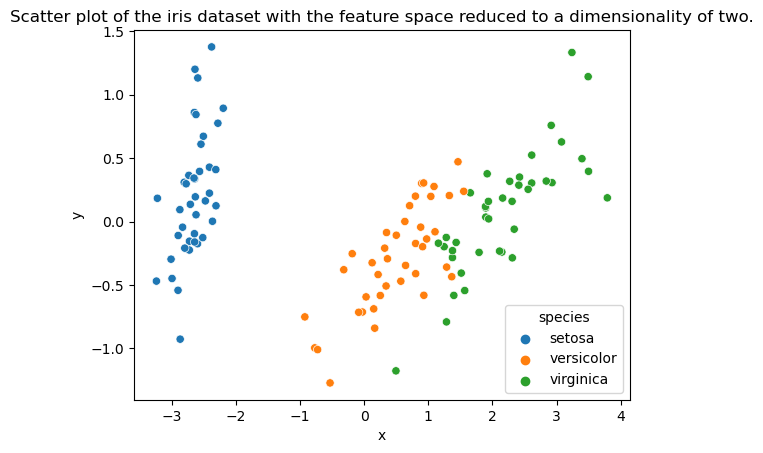

In [124]:
import seaborn as sns

pca_scatter = sns.scatterplot(x='x', y='y',data=iris_pca_df, hue='species')

pca_scatter.set(title='Scatter plot of the iris dataset with the feature space reduced to a dimensionality of two.')

Next follows a box plot of each feature grouped by its target. Also here, one can observe that in every case, flowers of the 'Setosa' species generally distinguish themselves more strongly than is the case with other species. Another interesting observation is that differences in petal dimensions seem to be generally more predictive in classifying the flower species than sepal dimensions.

Text(0.5, 1.05, 'Grid of boxplots of each feature where each subplot \n is grouped by the flower species.')

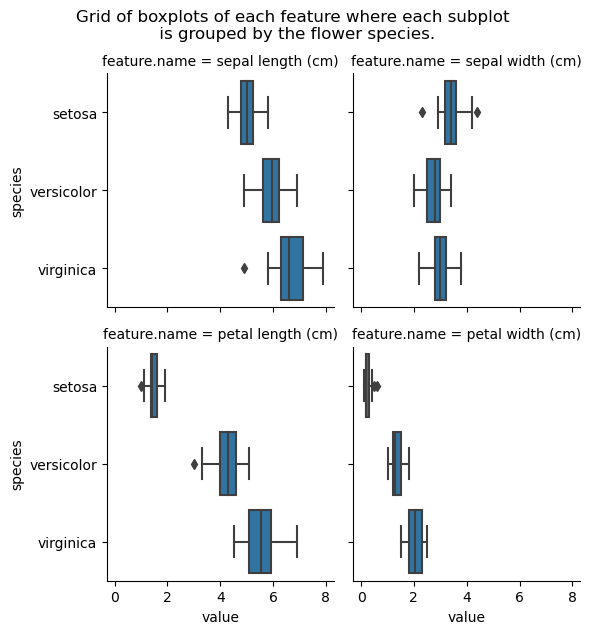

In [125]:
melted_iris_df = pd.melt(iris_df, id_vars=['species'], value_vars=columns, var_name='feature.name')
grid = sns.FacetGrid(data=melted_iris_df, col='feature.name', col_wrap=2)
box_grid = grid.map(sns.boxplot, 'value', 'species', order=['setosa', 'versicolor', 'virginica'])
grid.fig.suptitle('Grid of boxplots of each feature where each subplot \n is grouped by the flower species.', y=1.05)

The following plot verifies if the labels are unbalanced and as can be seen below the labels are perfectly balanced.

[Text(0.5, 1.0, 'Frequency of flowers by species.')]

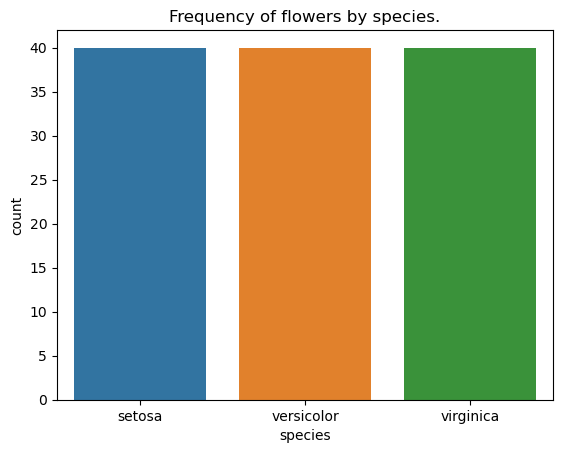

In [126]:
count = sns.countplot(data=iris_df, x='species')
count.set(title='Frequency of flowers by species.')

With the following plot again each feature is plotted against each other while on the diagonal of the grid empirical distributions are shown. We see that in every case that flowers of the species setosa form more separated clusters. Data points that represent flowers of either versicolor or virignica species, are more closer together but can still be linearly separated in most cases. A potential exception is in the plot where sepal.length and sepal.width dimensions are plotted where the flowers of each of the two species seem to be more almagamated. The plots on the diagonal also show that trend where the distributions each feature of the setosa flowers overlap less than the distributions of virgnica and versiocolor flowers.

Text(0.5, 1.01, 'Grid of scatterplots and plots of empirical distributions where each feature is plotted against each other feature \n and each individual sub plot is grouped by the species of the flower.')

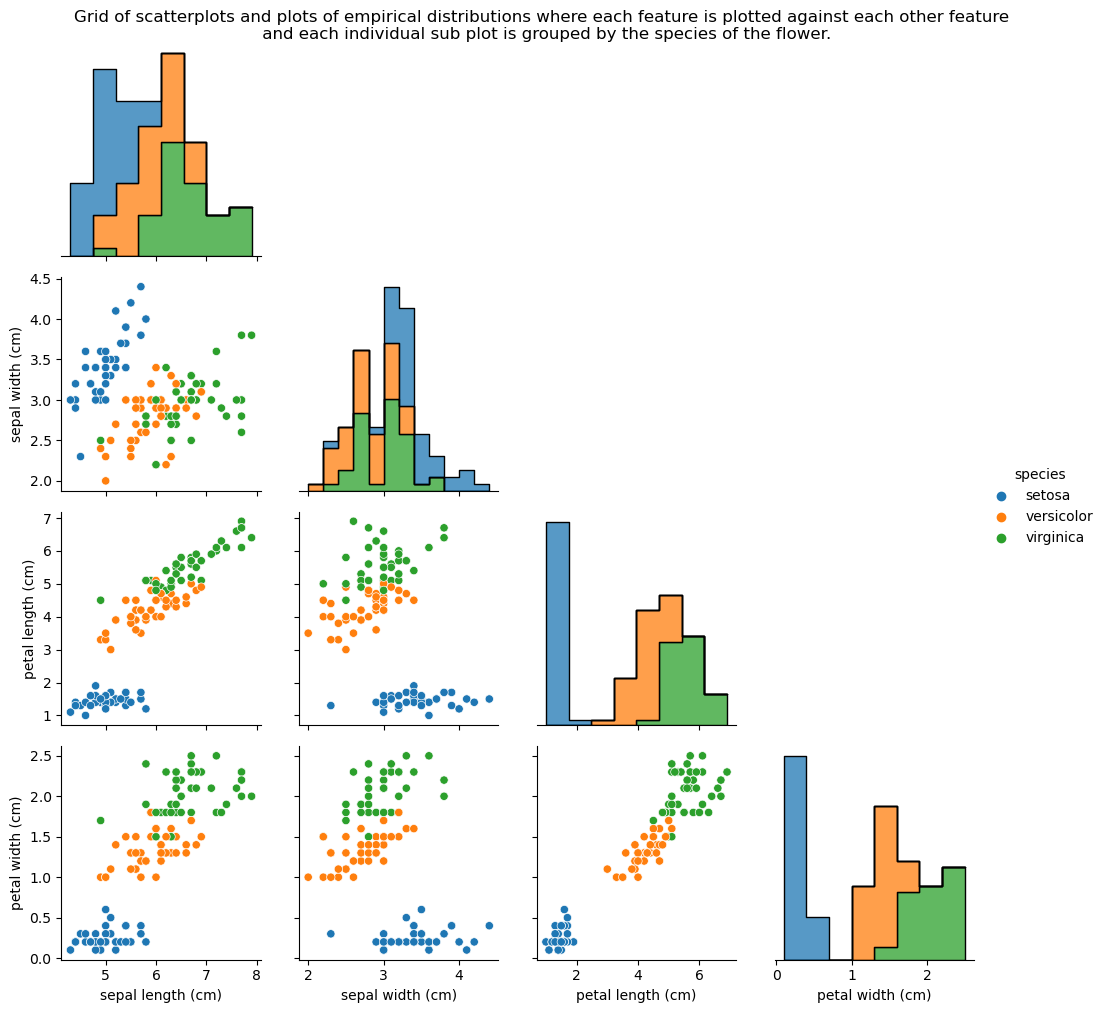

In [127]:
g = sns.PairGrid(iris_df.drop(['species.code'], axis=1), diag_sharey=False, corner=True, hue="species")
g.map_diag(sns.histplot, multiple="stack", element="step")
g.map_offdiag(sns.scatterplot)
g.add_legend()
g.fig.suptitle('Grid of scatterplots and plots of empirical distributions where each feature is plotted against each other feature \n and each individual sub plot is grouped by the species of the flower.', y=1.01)

From the correlation matrix shown below we can see strong correlation between features in many cases especially when looking at the sepal length, petal length and petal width features.

<Axes: >

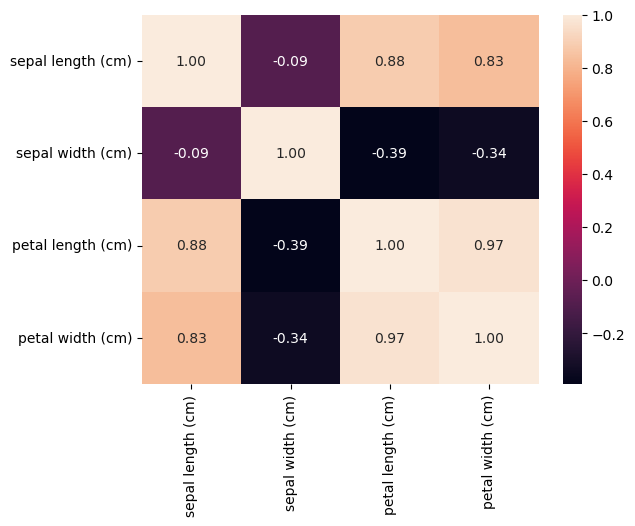

In [128]:
sns.heatmap(iris_df[columns].corr(), annot = True, fmt = '.2f')

## Data cleaning

In this step the existence of outliers will be examined. This is motivated by the fact that this dataset is very small, which means that outliers may have a strong influence on a models capacity to generalize from a dataset this small. To do this a special algorithm for this purpose will be used called Isolation Forest. We run the algorithm at first to retrieve anomaly scores and based on these scores we evaluate a statistic on those anomaly scores (In this case the statistic that was chosen was checking whether an indidual anomaly score is outside the range of 1.5 * IQR.) to make a more empirically informed guess of the contamination rate hyperparameter. The contamination rate is the expected percentage of samples in a dataset that are outliers.

In [129]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=100, random_state=0)
pred = iforest.fit_predict(iris_df[columns])
anomaly_scores = iforest.decision_function(iris_df[columns])

The following plot shows the distribution of anomaly scores. This distribution does not depend on the conatimination rate.

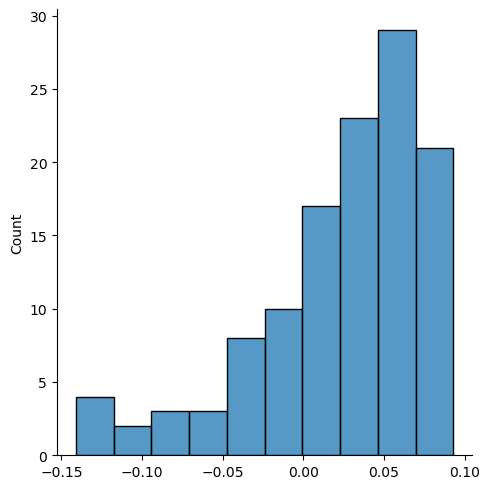

In [130]:
sns.displot(data=anomaly_scores)

From the box plot of the anomaly scores below we can observe that there are some data points that are outside the 1.5 * IQR range.

<Axes: >

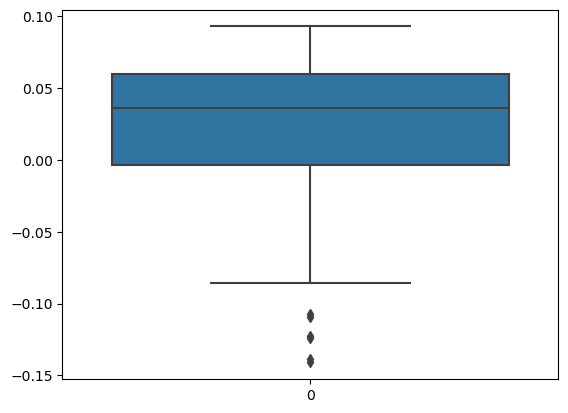

In [131]:
sns.boxplot(data=anomaly_scores)

The following code cell shows that precisely six data points are outside that range and could be considered as outliers.

In [132]:
import numpy as np
q3, q1 = np.percentile(anomaly_scores, [75, 25])
iqr = q3 - q1
number_of_outliers = anomaly_scores[(anomaly_scores > q3 + 1.5 * iqr) | (anomaly_scores < q1 - 1.5 * iqr)].size
number_of_outliers

6

This cell fits a new ensemble of Isolation Forests now with a contamination rate that equals the proportion of data points whose anomaly score is outside 1.5 * IQR. The final scatter plot shows the exact data points that are considered outliers by the algorithm and the results seem overall quite promising.

c:\Users\marko\miniconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


<Axes: xlabel='x', ylabel='y'>

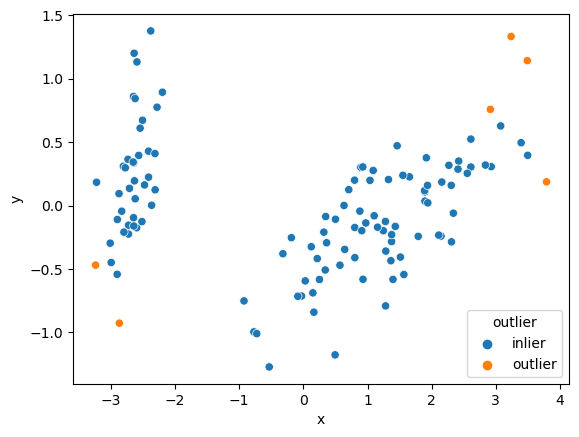

In [133]:
iforest = IsolationForest(n_estimators=100, contamination=number_of_outliers/iris_df.shape[0], random_state=0)
pred = iforest.fit_predict(iris_df[columns])

iris_pca_df['outlier'] = pred
iris_pca_df['outlier'] = iris_pca_df['outlier'].map(lambda x: 'outlier' if x == -1 else 'inlier')
sns.scatterplot(data=iris_pca_df, x='x',y='y', hue='outlier')

Next the outliers are removed from the dataset.

In [134]:
iris_df['outlier'] = pred
iris_df = iris_df[iris_df['outlier'] == 1]
iris_df.drop('outlier', axis=1)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species.code,species
0,4.8,3.0,1.4,0.3,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.4,3.0,1.3,0.2,0,setosa
3,5.0,3.4,1.5,0.2,0,setosa
4,5.8,2.7,3.9,1.2,1,versicolor
...,...,...,...,...,...,...
114,6.9,3.1,4.9,1.5,1,versicolor
115,6.7,3.0,5.2,2.3,2,virginica
116,4.9,3.1,1.5,0.2,0,setosa
118,6.4,2.8,5.6,2.1,2,virginica


The following code cell verifies whether there are any missing values and as can be seen below there are none.

<Axes: >

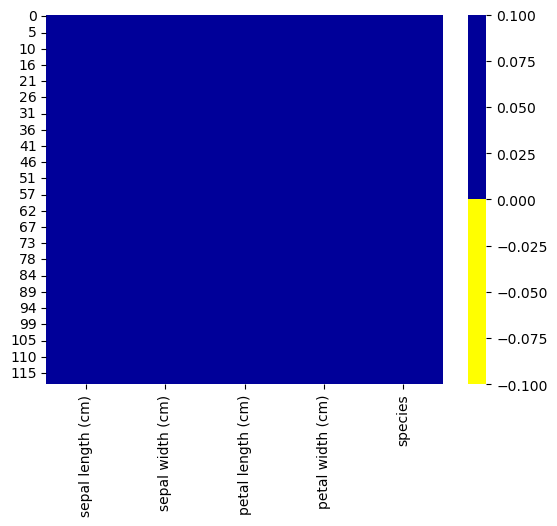

In [135]:
colours = ['#ffff00', '#000099']

sns.heatmap(iris_df.drop(['outlier', 'species.code'], axis=1).isnull(),cmap=sns.color_palette(colours))

# Feature engineering

We see that the features have strongly varying means and standard deviations warranting the use of Scaling each feature.

In [136]:
iris_df[columns].mean(), iris_df[columns].std()

(sepal length (cm)    5.821053
 sepal width (cm)     3.042105
 petal length (cm)    3.707018
 petal width (cm)     1.188596
 dtype: float64,
 sepal length (cm)    0.785992
 sepal width (cm)     0.436984
 petal length (cm)    1.724766
 petal width (cm)     0.749130
 dtype: float64)

In [137]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_iris = scaler.fit_transform(iris_df[columns])

Due to the high degree of correlation and the small quantity of features, the usage of PCA is waranted. PCA makes sure that the new set of features are orthogonal to each other therefore ensuring that they are decorrelated. We made sure to take as many features as are needed to explain at least 99% of the variance of the original data. This results in 3 components and an explained variance ration of rougly 99.5%.

In [138]:
pca = PCA(n_components=0.99)
iris_pca_features_df = pca.fit_transform(scaled_iris)
print(f'number of components: {pca.n_components_}')
print(f'explained variance: {pca.explained_variance_ratio_.sum()}')

number of components: 3
explained variance: 0.9951045808155407
